Отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

И сделать это можно с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы (вот она, сила ML!). Чтобы определиться с параметрами будущей модели, проведите разведывательный анализ данных и составьте отчёт по его результатам. 

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import ttest_ind
stud_set = pd.read_csv('stud_math.csv')
stud_set.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


Проверим названия колонок

In [82]:
stud_set.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

Посмотрим на данные в столбцах

In [83]:
stud_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-null object
studytime, granular    388 non-

School


In [84]:
pd.DataFrame(stud_set.school.value_counts())
stud_set['school_bin'] = stud_set.school.apply(lambda x: int(
    x.replace('GP', '1')) if x == 'GP' else int(x.replace('MS', '0')))

всего два значения, можно разбить на бинарные значения, gp - 0 b ms - 1 или get.dummy, пропусков нет, большинство учеников школы GP

Sex

In [85]:
pd.DataFrame(stud_set.sex.value_counts())
stud_set['sex_bin'] = stud_set.sex.apply(lambda x: int(
    x.replace('F', '0')) if x == 'F' else int(x.replace('M', '1')))
pd.DataFrame(stud_set.sex_bin.value_counts())

,sex_bin
0,208
1,187


Аналогичен предыдущему, заменим на 0 и 1, без пропусков, примерно поровну обоих полов

 AGE 
 
 числовой столбец, обещали от 15 до 22. Проверим на выбросы и посмотрим распределение

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

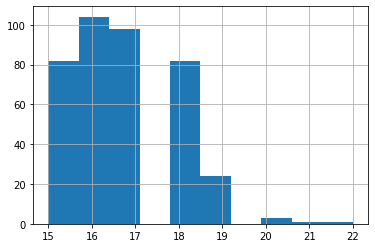

In [86]:
stud_set.age.hist()
stud_set.age.describe()

Распределение близко к нормальному, пропусков нет, выбросами  можно посчитать возраст старше 19 лет, это - около 1 % (5), большая часть находится в интервале от 16 до 18 лет, но если пользоваться межквартильным расстоянием для определения выбросов - теряется много информации (15-летние)

In [87]:
stud_set = stud_set.loc[stud_set.age <= 19]

Address

Бинарный столбец, можно преобразовать в dummy, преобладают дети, живущие в городе, есть пропуски, но их немного, стоит их заменить на городских (как наиболее часто встречающееся), а можно посмотреть на распределение адресов в зависимости от школы и заменить на самое часто встречающееся в данной школе).

In [88]:
stud_set.address.groupby(stud_set.school).value_counts()

school  address
GP      U          275
        R           60
MS      R           22
        U           17
Name: address, dtype: int64

Учитывая малый обьем выборки по второй школе - заменим Nan на чаще всего встречающееся во всей выборке - на U
В последующем применим метод get_dummies

In [89]:
stud_set.address = stud_set.address.fillna('U')
stud_set['address_bin'] = stud_set.address.apply(lambda x: int(
    x.replace('U', '1')) if x == 'U' else int(x.replace('R', '0')))

Family size (famsize)

Бинарный столбец, нет данных о точном количестве человек в семье, два-три или больше трех. Проверим на пропуски, посчитаем значения, заменим пропуски на наиболее часто встречающееся, применим get_dummies

In [90]:
stud_set.famsize. value_counts()

GT3    257
LE3    106
Name: famsize, dtype: int64

Пропуски есть, их немного, заменим пропуски на GT3

In [91]:
stud_set.famsize = stud_set.famsize.fillna('GT3')
stud_set['famsize_bin'] = stud_set.famsize.apply(lambda x: int(
    x.replace('GT3', '1')) if x == 'GT3' else int(x.replace('LE3', '0')))

Pstatus


номинативный бинарный столбец, пропусков достаточно много, посмотрим значения

In [92]:
stud_set.Pstatus.value_counts()

T    311
A     34
Name: Pstatus, dtype: int64

В основном - полные семьи, можем смело заменять пропуски на Т 

In [93]:
stud_set.Pstatus = stud_set.Pstatus.fillna('T')
stud_set['Pstatus_bin'] = stud_set.Pstatus.apply(lambda x: int(
    x.replace('T', '1')) if x == 'T' else int(x.replace('A', '0')))

Medu, Fedu 
категориальные переменные, уже разбитые по возрастанию, посмторим распределение и выбросы. Пропуски есть, их немного

4.0    130
2.0    101
3.0     95
1.0     58
0.0      3
Name: Medu, dtype: int64

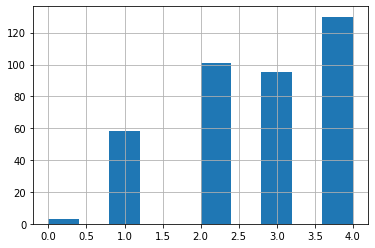

In [94]:
stud_set.Medu.hist()
stud_set.Medu.describe()
stud_set.Medu.value_counts()

2.0     103
3.0      96
4.0      88
1.0      76
0.0       2
40.0      1
Name: Fedu, dtype: int64

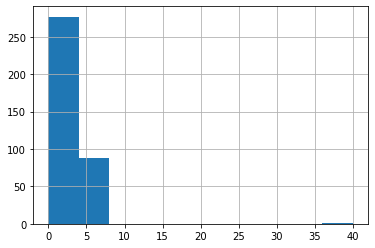

In [95]:
stud_set.Fedu.hist()
stud_set.Fedu.describe()
stud_set.Fedu.value_counts()

Столбец Medu - распределение близко к нормальному, не считая 3 женщин без образования. пропуски можно заменить медианой

Столбец Fedu - есть выбросы, выходчящие за пределы допустимых значчений, также 0 - всего в двух наблюдениях,  удалим их и снова посмотрим распределение, пропуски заменим медианой

In [96]:
stud_set.Medu = stud_set.Medu.fillna(stud_set.Medu.median())
stud_set = stud_set.loc[stud_set.Medu > 0]

In [97]:
stud_set = stud_set.loc[stud_set.Fedu <= 4]
stud_set = stud_set.loc[stud_set.Fedu > 0]
stud_set.Fedu = stud_set.Fedu.fillna(3.0)
pd.DataFrame(stud_set.Fedu.value_counts())

,Fedu
2.0,101
3.0,96
4.0,88
1.0,75


In [98]:
stud_set.Fedu.describe()

count    360.000000
mean       2.547222
std        1.075425
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: Fedu, dtype: float64

In [99]:
stud_set.Medu.value_counts()

4.0    119
2.0     96
3.0     91
1.0     54
Name: Medu, dtype: int64

Mjob, Fjob

Категориальные переменные, посмотрим распределение, заменить можно будет с помощью get_dummies, так как нумеровать смысла нет, категории не ординарные. 

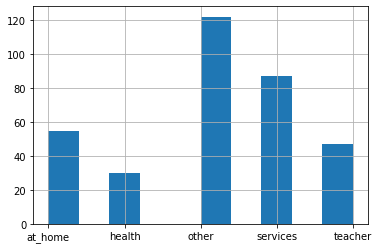

In [100]:
stud_set.Mjob.hist()

In [101]:
stud_set.Mjob.describe()

count       341
unique        5
top       other
freq        122
Name: Mjob, dtype: object

Есть пропуски, однозначного решения нет, но можно попробовать заменить на top - значение, для этого созддим новый столбец.  

count       326
unique        5
top       other
freq        182
Name: Fjob, dtype: object

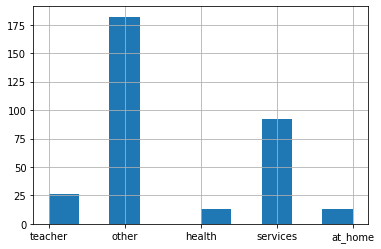

In [102]:
stud_set.Fjob.hist()
stud_set.Fjob.describe()

Пропусков много, top выражен (примерно половина наблюдений), можно заменить Nan на top

In [103]:
stud_set.Fjob = stud_set.Fjob.fillna('other')
stud_set.Mjob = stud_set.Mjob.fillna('other')
Fjob_dummy = pd.get_dummies(stud_set.Fjob, drop_first=True)
Mjob_dummy = pd.get_dummies(stud_set.Mjob, drop_first=True)

reason

Аналогичен предыдущим столбцам, пропуски есть, категориальные признаки, неординарные, посмотрим, можно ли заменить пропуски

count        344
unique         4
top       course
freq         122
Name: reason, dtype: object

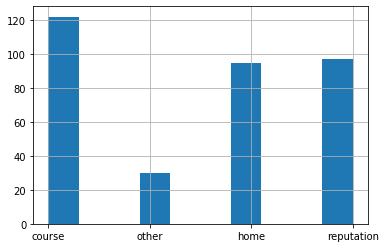

In [104]:
stud_set.reason.hist()
stud_set.reason.describe()

Пропусков гораздо меньше, чем в столбце Fjob, но распределение не однозначное, попробуем заменить пропуски на top-значение

In [105]:
stud_set['reason_fillna'] = stud_set.reason.fillna('course')

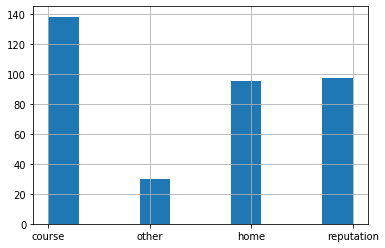

In [106]:
stud_set.reason_fillna.hist()

 guardian
 
 Категориальный признак, пропусков мало, посмотрим распределение, выбросы и топ-значение

count        333
unique         3
top       mother
freq         232
Name: guardian, dtype: object

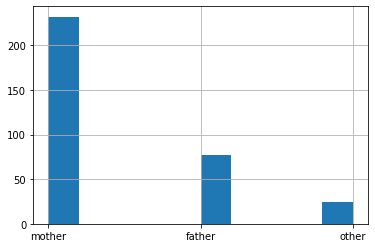

In [107]:
stud_set.guardian.hist()
stud_set.guardian.describe()

In [108]:
stud_set.guardian = stud_set.guardian.fillna('mother')
stud_set.guardian.value_counts()

mother    259
father     77
other      24
Name: guardian, dtype: int64

traveltime

ординарный признак, численный. 

count    335.000000
mean       1.450746
std        0.706974
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

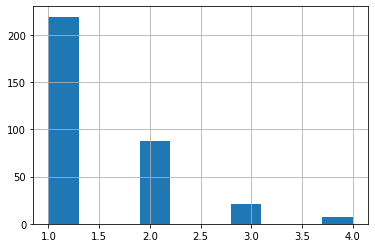

In [109]:
stud_set.traveltime.hist()
stud_set.traveltime.describe()

In [110]:
stud_set.traveltime.value_counts()

1.0    219
2.0     88
3.0     21
4.0      7
Name: traveltime, dtype: int64

Распределение нормальное, выбросов нет, пропусков около 30, заменим медианным значением

In [111]:
stud_set.traveltime = stud_set.traveltime.fillna(1.0)

studytime

Аналогичен предыдущему, пропусков почти нет. 

count    353.000000
mean       2.028329
std        0.835499
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

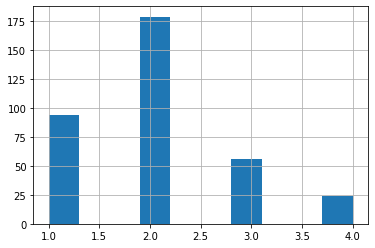

In [112]:
stud_set.studytime.hist()
stud_set.studytime.describe()

In [113]:
stud_set.studytime = stud_set.studytime.fillna(2.0)
stud_set.studytime.value_counts()

2.0    186
1.0     94
3.0     56
4.0     24
Name: studytime, dtype: int64

failures

Числовой признак, ищем выбросы и пропуски. 

In [114]:
stud_set.failures.describe()

count    342.000000
mean       0.307018
std        0.703496
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

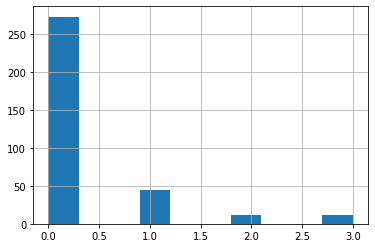

In [115]:
stud_set.failures.hist()

 top - 0, пропусков 18, можем заменить их на 0

In [116]:
stud_set.failures = stud_set.failures.fillna(0.0)

Следующие несколько столбцов имеют одинаковую структуру, они бинарные (Yes or No), можем заменить их на значения 1 и 0, чтобы их также можно было использовать в модели.

schoolsup

дополнительная образовательная поддержка, бинарное значение, создадим новый столбец, заменим пропуски на top

In [117]:
pd.DataFrame(stud_set.schoolsup.value_counts())

,schoolsup
no,305
yes,47


In [118]:
stud_set['schoolsup_bin'] = stud_set.schoolsup.map(
    {'yes': 1, 'no': 0}).fillna(0)
stud_set['schoolsup_bin']

0      1.0
1      0.0
2      1.0
3      0.0
4      0.0
      ... 
388    0.0
389    0.0
391    0.0
393    0.0
394    0.0
Name: schoolsup_bin, Length: 360, dtype: float64

famsup

семейная образовательная поддержка, top - yes, заменим на него пропуски

In [119]:
pd.DataFrame(stud_set.famsup.value_counts())

,famsup
yes,201
no,125


In [120]:
stud_set['famsup_bin'] = stud_set.famsup.map({'yes': 1, 'no': 0}).fillna(1)

In [121]:
stud_set['famsup_bin']

0      0.0
1      1.0
2      0.0
3      1.0
4      1.0
      ... 
388    1.0
389    0.0
391    0.0
393    0.0
394    0.0
Name: famsup_bin, Length: 360, dtype: float64

paid

Доп.занятия по математике, посмотрим количество пропусков, заменим нa top.

In [122]:
pd.DataFrame(stud_set.paid.value_counts())

,paid
no,182
yes,141


In [123]:
stud_set['paid_bin'] = stud_set.paid.map({'yes': 1, 'no': 0}).fillna(0)
stud_set.paid_bin

0      0.0
1      0.0
2      0.0
3      1.0
4      1.0
      ... 
388    1.0
389    0.0
391    0.0
393    0.0
394    0.0
Name: paid_bin, Length: 360, dtype: float64

activities

дополнительные внеучебные занятия, посмотрим пропуски, top, создадим новый столбец без пропусков

In [124]:
pd.DataFrame(stud_set.activities.value_counts())

,activities
yes,177
no,169


In [125]:
stud_set['act_bin'] = stud_set.activities.map({'yes': 1, 'no': 0}).fillna(1)
stud_set['act_bin']

0      0.0
1      0.0
2      0.0
3      1.0
4      0.0
      ... 
388    0.0
389    1.0
391    0.0
393    1.0
394    0.0
Name: act_bin, Length: 360, dtype: float64

In [126]:
stud_set['act_bin'].value_counts()

1.0    191
0.0    169
Name: act_bin, dtype: int64

nursery

In [127]:
stud_set.nursery.value_counts()

yes    274
no      71
Name: nursery, dtype: int64

In [128]:
stud_set['nurs_bin'] = stud_set.nursery.map({'yes': 1, 'no': 0}).fillna(1)

In [129]:
stud_set['nurs_bin'].value_counts()

1.0    289
0.0     71
Name: nurs_bin, dtype: int64

higher

Заинтересованность в высшем образовании, аналогично предыдущим столбцам

In [130]:
stud_set.higher.value_counts()

yes    328
no      17
Name: higher, dtype: int64

In [131]:
stud_set['high_bin'] = stud_set.higher.map({'yes': 1, 'no': 0}).fillna(1)
stud_set.high_bin.value_counts()

1.0    343
0.0     17
Name: high_bin, dtype: int64

internet

Наличие домашнего интернета

In [132]:
stud_set.internet.value_counts()

yes    277
no      50
Name: internet, dtype: int64

In [133]:
stud_set['net_bin'] = stud_set.internet.map({'yes': 1, 'no': 0}).fillna(1)
stud_set.net_bin.value_counts()

1.0    310
0.0     50
Name: net_bin, dtype: int64

romantic

Состоит ли в романтических отношениях

In [134]:
stud_set.romantic.value_counts()

no     219
yes    113
Name: romantic, dtype: int64

In [135]:
stud_set['roman_bin'] = stud_set.romantic.map({'yes': 1, 'no': 0}).fillna(0)
stud_set.roman_bin.value_counts()

0.0    247
1.0    113
Name: roman_bin, dtype: int64

famrel


Как и последующие три столбца - категориальный, ординарный признак, нужно исследовать на пропуски и, по возможности, их исправить.

count    336.000000
mean       3.928571
std        0.940444
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

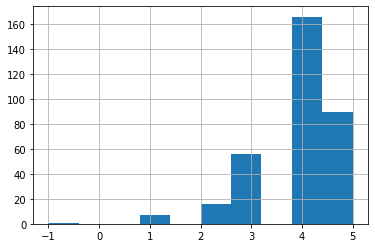

In [136]:
stud_set.famrel.hist()
stud_set.famrel.describe()

In [137]:
stud_set.famrel.value_counts()

 4.0    166
 5.0     90
 3.0     56
 2.0     16
 1.0      7
-1.0      1
Name: famrel, dtype: int64

Есть выброс (-1), от него можно избавиться. Есть пропуски, их можно заполнить медианой:

In [138]:
stud_set.famrel = stud_set.famrel.fillna(4.0)
stud_set = stud_set.loc[stud_set.famrel > 0]

freetime


свободное время после школы, от 1 до 5 по возрастанию, ищем выбросы, пропуски, заменяем медианой

count    350.000000
mean       3.200000
std        0.992811
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

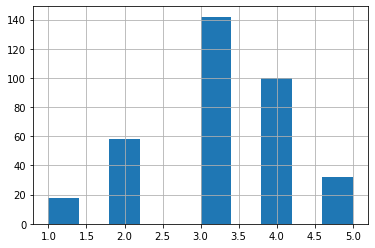

In [139]:
stud_set.freetime.hist()
stud_set.freetime.describe()

Распределение близко к нормальному, выбросов нет, пропуски заполним медианой (3.0)

In [140]:
stud_set.freetime = stud_set.freetime.fillna(3.0)

goout

проведение времени с друзьями, от 1 до 5 по возрастанию, ищем выбросы, пропуски, заменяем медианой

count    351.000000
mean       3.111111
std        1.116969
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

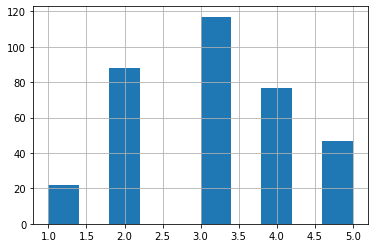

In [141]:
stud_set.goout.hist()
stud_set.goout.describe()

In [142]:
stud_set.goout = stud_set.goout.fillna(3.0)

Аналогичен предыдущему, выбросов нет

Health

состояние здоровья, от 1 до 5 по возрастанию, ищем выбросы, пропуски, заменяем медианой

count    346.000000
mean       3.508671
std        1.398212
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

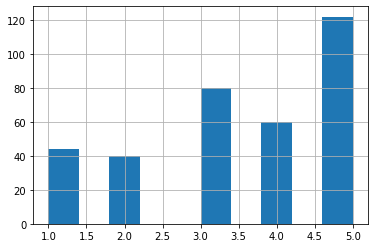

In [143]:
stud_set.health.hist()
stud_set.health.describe()

In [144]:
stud_set.health = stud_set.health.fillna(4.0)

Распределение признака не являяется нормальным, но из-за небольшой выборки отсекать по квартилям не стоит, так как потеряется слишком много данных. попробуем только заменить медианой пропуски.

Absences

Числовая переменная, пропуски есть, но их немного, посмотрим, как со значениями и выбросами

count    347.000000
mean       6.832853
std       21.954782
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

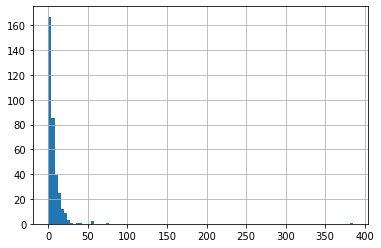

In [145]:
stud_set.absences.hist(bins=100)
stud_set.absences.describe()

In [146]:
stud_set.absences.value_counts()

0.0      102
2.0       55
4.0       47
6.0       29
8.0       20
10.0      15
12.0      11
14.0      10
3.0        7
16.0       6
7.0        5
18.0       5
5.0        4
20.0       4
22.0       3
1.0        3
9.0        3
15.0       2
13.0       2
54.0       1
25.0       1
385.0      1
26.0       1
56.0       1
17.0       1
28.0       1
21.0       1
75.0       1
38.0       1
40.0       1
23.0       1
11.0       1
24.0       1
Name: absences, dtype: int64

Посчитаем количество пропусков более 25 выбросами и удалим. Пропуски заменим медианой.

In [147]:
stud_set.absences = stud_set.absences.fillna(4.0)
stud_set = stud_set.loc[stud_set.absences < 100]

score
Численный, есть пропуски, от них избавимся, так как этот столбец нужно будет предсказывать. 

count    352.000000
mean      51.946023
std       22.748593
min        0.000000
25%       40.000000
50%       55.000000
75%       66.250000
max      100.000000
Name: score, dtype: float64

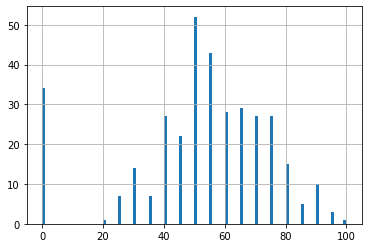

In [148]:
stud_set.score.hist(bins=100)
stud_set.score.describe()

In [149]:
stud_set.score = stud_set.score.dropna()
stud_set = stud_set.loc[stud_set.score > 0]

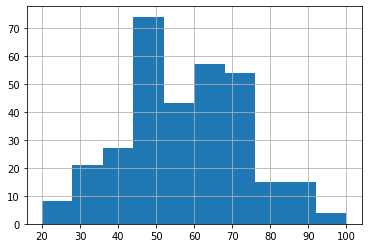

In [150]:
stud_set.score.hist()

stud_set.columns

В целом распределение близко к нормальному, далее посмотрим, что можно будет ипользовать в модели. 
Для этого сформируем оставшиеся количественные столбцы в тестовый сет, посмотрим корреляцию:

In [159]:
stud_set_test = stud_set.loc[:, ['age', 'Medu', 'Fedu', 'traveltime', 'studytime',
                                 'failures', 'studytime, granular', 'famrel',
                                 'freetime', 'goout', 'health', 'absences', 'score', 'school_bin',
                                 'sex_bin', 'address_bin', 'famsize_bin', 'Pstatus_bin',
                                 'schoolsup_bin', 'famsup_bin', 'paid_bin', 'act_bin', 'nurs_bin',
                                 'high_bin', 'net_bin', 'roman_bin']]

In [160]:
corr = stud_set_test.corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)


def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
            ]


corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score,school_bin,sex_bin,address_bin,famsize_bin,Pstatus_bin,schoolsup_bin,famsup_bin,paid_bin,act_bin,nurs_bin,high_bin,net_bin,roman_bin
age,1,-0.12,-0.095,0.14,0.03,0.11,-0.03,0.0073,-0.095,0.093,-0.029,0.23,-0.15,-0.36,-0.044,-0.16,-0.04,0.049,-0.26,-0.089,-0.019,-0.12,-0.032,-0.14,-0.053,0.21
Medu,-0.12,1,0.63,-0.18,0.065,-0.2,-0.066,-0.033,0.014,0.043,-0.043,0.048,0.22,0.13,0.05,0.18,0.041,-0.13,-0.058,0.18,0.15,0.087,0.17,0.2,0.19,0.054
Fedu,-0.095,0.63,1,-0.15,-0.013,-0.23,0.013,-0.024,-0.00078,0.045,-0.0092,0.023,0.14,0.056,0.043,0.096,0.087,-0.11,0.033,0.18,0.089,0.11,0.16,0.15,0.15,0.044
traveltime,0.14,-0.18,-0.15,1,-0.13,0.12,0.13,-0.049,-0.0071,0.036,0.0028,0.0022,-0.087,-0.23,0.066,-0.25,-0.067,0.078,0.0038,0.003,-0.041,0.0035,-0.045,-0.16,-0.091,0.054
studytime,0.03,0.065,-0.013,-0.13,1,-0.12,-1,0.06,-0.12,-0.022,-0.056,-0.057,0.15,0.1,-0.27,-0.066,0.082,-0.05,0.0027,0.12,0.21,0.084,0.053,0.13,0.053,0.075
failures,0.11,-0.2,-0.23,0.12,-0.12,1,0.12,-0.018,0.066,0.11,0.081,0.14,-0.27,0.032,-0.0002,-0.075,-0.053,0.026,0.086,-0.054,-0.13,0.0085,0.0058,-0.22,-0.051,0.08
"studytime, granular",-0.03,-0.066,0.013,0.13,-1,0.12,1,-0.061,0.12,0.022,0.057,0.057,-0.15,-0.1,0.27,0.066,-0.083,0.05,-0.0032,-0.12,-0.22,-0.086,-0.053,-0.13,-0.053,-0.075
famrel,0.0073,-0.033,-0.024,-0.049,0.06,-0.018,-0.061,1,0.13,0.021,0.13,-0.039,0.033,0.098,0.034,0.035,0.015,0.0093,0.02,0.032,-0.024,0.07,-0.0064,-0.0098,0.11,-0.1
freetime,-0.095,0.014,-0.00078,-0.0071,-0.12,0.066,0.12,0.13,1,0.27,0.092,-0.092,-0.007,-0.0098,0.18,0.088,-0.013,0.084,-0.059,0.07,-0.018,0.13,-0.017,0.0025,0.14,-0.039
goout,0.093,0.043,0.045,0.036,-0.022,0.11,0.022,0.021,0.27,1,0.029,0.0065,-0.17,-0.017,0.057,0.093,-0.024,0.056,-0.032,-0.014,0.079,0.065,0.032,0.031,0.13,0.023


Выраженная линейная зависимость между столбцами образования матери и отца (Medu, Fedu) - 0,63, обратная прямая зависимость между studytime & studytime granular, также слабая, но ближе к средней - между school_bin, traveltime  и address_bin, а также между studytime и paid_bin, между age и absenses, между age  и schoolsup. Cо score ближе к средней - failures, absenses и schoolsup_bin, Medu. 
Из итогового датасета удаляем Medu, traveltime, studytime & studytime gr, address_bin, failures, schoolsup_bin, absenses, как наиболее скоррелированные с целевой переменной.

In [166]:
ML_stud_set = stud_set_test.loc[:, ['age', 'Fedu', 'famrel',
                                    'freetime', 'goout', 'health', 'score', 'school_bin',
                                    'sex_bin', 'famsize_bin', 'Pstatus_bin',
                                    'famsup_bin', 'paid_bin', 'act_bin', 'nurs_bin',
                                    'high_bin', 'net_bin', 'roman_bin']]

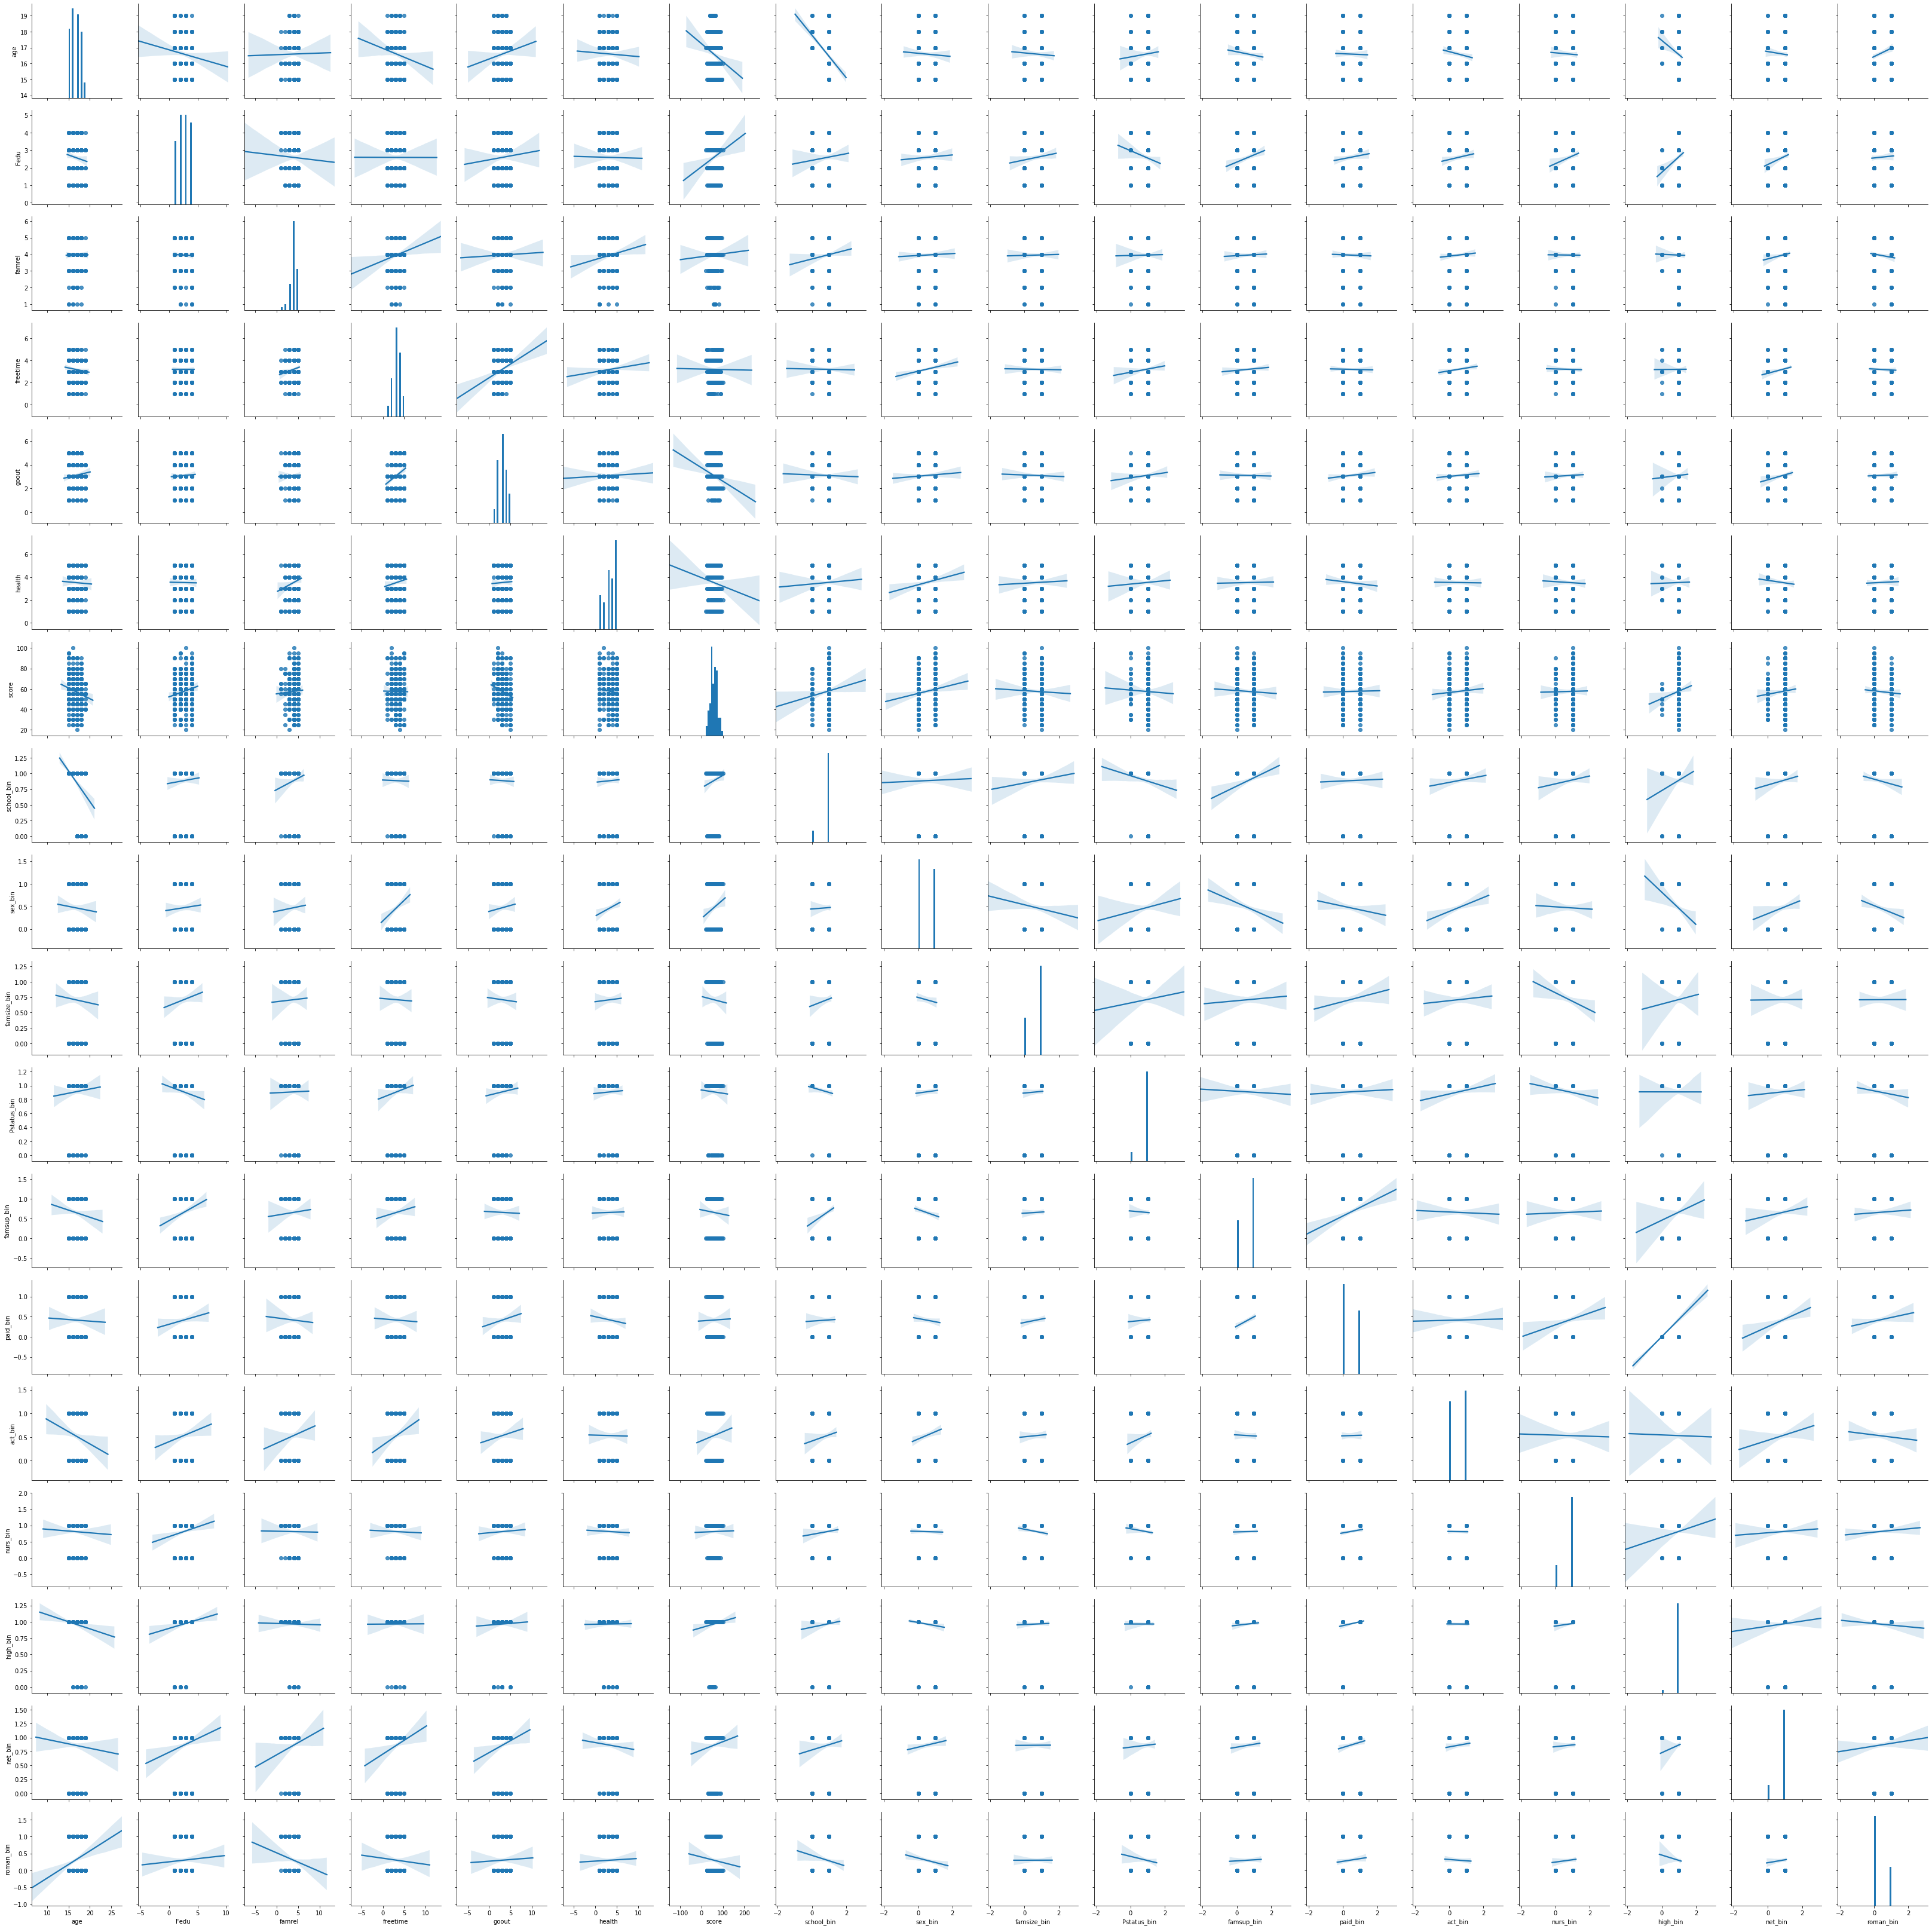

In [164]:
sns.pairplot(ML_stud_set, kind='reg')

In [167]:
# Итоговый датасет:
ML_stud_set

,age,Fedu,famrel,freetime,goout,health,score,school_bin,sex_bin,famsize_bin,Pstatus_bin,famsup_bin,paid_bin,act_bin,nurs_bin,high_bin,net_bin,roman_bin
0,18,4.0,4.0,3.0,4.0,3.0,30.0,1,0,1,0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1,17,1.0,5.0,3.0,3.0,3.0,30.0,1,0,1,1,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,15,1.0,4.0,3.0,2.0,3.0,50.0,1,0,0,1,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,15,2.0,3.0,2.0,2.0,5.0,75.0,1,0,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,16,3.0,4.0,3.0,2.0,5.0,50.0,1,0,1,1,1.0,1.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,18,4.0,4.0,4.0,3.0,5.0,30.0,0,0,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
388,18,1.0,4.0,3.0,4.0,1.0,40.0,0,0,0,1,1.0,1.0,0.0,1.0,1.0,1.0,0.0
391,17,1.0,2.0,4.0,5.0,2.0,80.0,0,1,0,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0
393,18,2.0,4.0,4.0,1.0,5.0,50.0,0,1,0,1,0.0,0.0,1.0,0.0,1.0,1.0,0.0


В итоговый датасет попали наименее скоррелированные между собой и с целевой переменной признаки, данные с большим количеством пропусков, большую часть пришлось заменить на медиану или top- значение, что-то убрать совсем. Итоговый датасет - без пропусков, все признаки - численные, линейно независимые. 